## A tutorial for Bivariate Mapping

Using https://github.com/mikhailsirenko/bivariate-choropleth/blob/main/bivariate-choropleth.ipynb 

In [1]:
# Import required packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from adjustText import adjust_text
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler


from scipy import stats

import os
os.chdir(os.getcwd()+'/Bivariate_mapping')

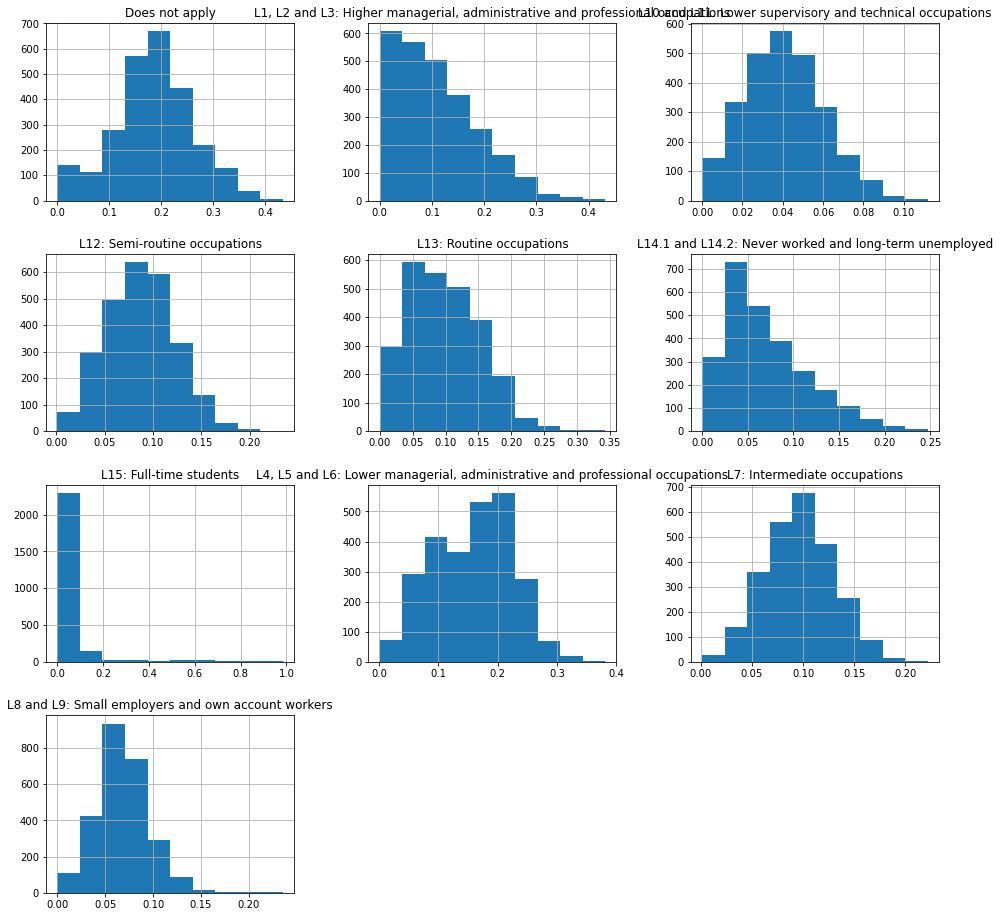

In [2]:
# read in ns-sec classificaiton (census) data for Leeds by Output Area (OA)
ns_sec=pd.read_csv('TS062-2021-2-filtered-2023-03-13T16-35-51Z.csv')

#pivot data to get columns as ns-sec category and rows as OA
ns_sec_by_OA =pd.pivot(ns_sec, index='Output Areas Code', columns='National Statistics Socio-economic Classification (NS-SeC) (10 categories)', values='Observation').reset_index()

# calculate total observations per OA
ns_sec_by_OA['total']=ns_sec_by_OA[['Does not apply',
       'L1, L2 and L3: Higher managerial, administrative and professional occupations',
       'L10 and L11: Lower supervisory and technical occupations',
       'L12: Semi-routine occupations', 'L13: Routine occupations',
       'L14.1 and L14.2: Never worked and long-term unemployed',
       'L15: Full-time students',
       'L4, L5 and L6: Lower managerial, administrative and professional occupations',
       'L7: Intermediate occupations',
       'L8 and L9: Small employers and own account workers']].sum(axis=1)
# Set OA as index
ns_sec_by_OA=ns_sec_by_OA.set_index('Output Areas Code')

# use total observations per OA to calculate proportion
ns_sec_by_OA_prop =ns_sec_by_OA[['Does not apply',
       'L1, L2 and L3: Higher managerial, administrative and professional occupations',
       'L10 and L11: Lower supervisory and technical occupations',
       'L12: Semi-routine occupations', 'L13: Routine occupations',
       'L14.1 and L14.2: Never worked and long-term unemployed',
       'L15: Full-time students',
       'L4, L5 and L6: Lower managerial, administrative and professional occupations',
       'L7: Intermediate occupations',
       'L8 and L9: Small employers and own account workers']].div(ns_sec_by_OA['total'],axis=0)

#Visualise proportional distrbution
ns_sec_by_OA_prop[['Does not apply',
       'L1, L2 and L3: Higher managerial, administrative and professional occupations',
       'L10 and L11: Lower supervisory and technical occupations',
       'L12: Semi-routine occupations', 'L13: Routine occupations',
       'L14.1 and L14.2: Never worked and long-term unemployed',
       'L15: Full-time students',
       'L4, L5 and L6: Lower managerial, administrative and professional occupations',
       'L7: Intermediate occupations',
       'L8 and L9: Small employers and own account workers']].hist(figsize=(16,16));

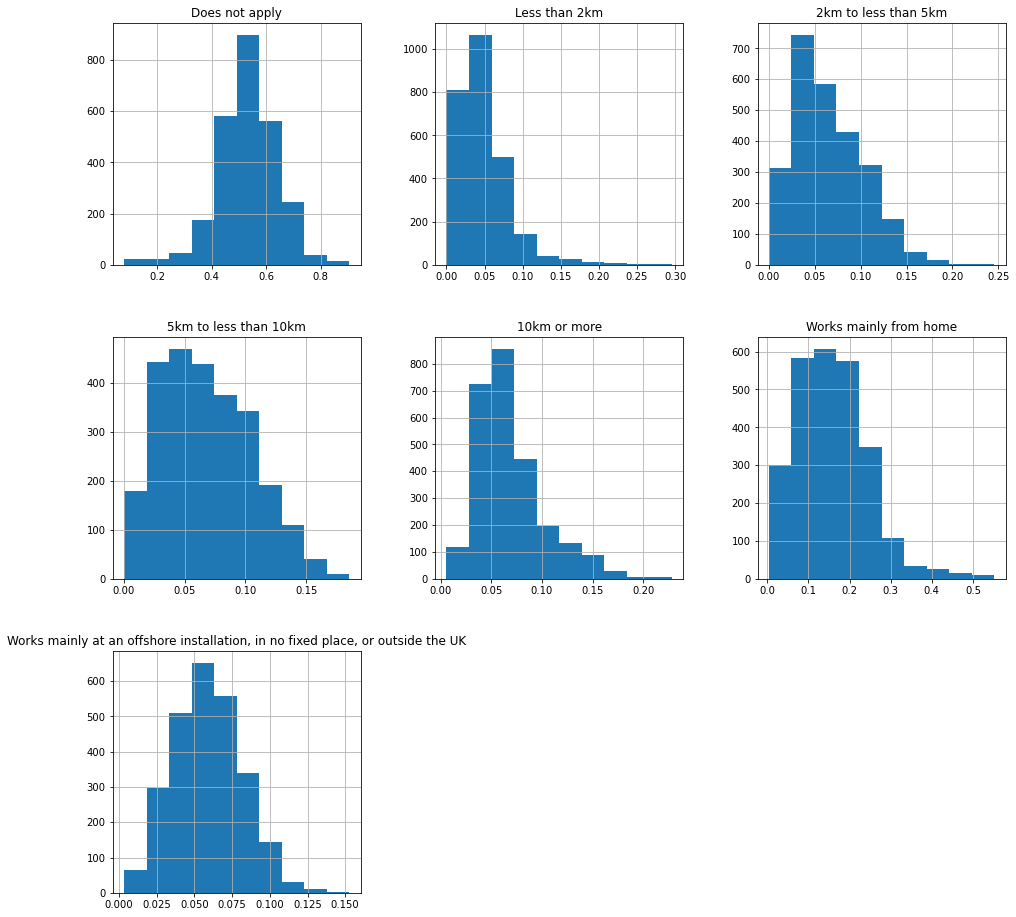

In [3]:
travel_to_work= pd.read_csv('TS058-2021-3-filtered-2023-03-13T16-34-18Z.csv')
#pivot data to get columsn as nsec and rows as OA
travel_to_work_by_OA =pd.pivot(travel_to_work, index='Output Areas Code', columns='Distance travelled to work (11 categories)', values='Observation').reset_index()
#
travel_to_work_by_OA['total']=travel_to_work_by_OA[['10km to less than 20km', '20km to less than 30km',
       '2km to less than 5km', '30km to less than 40km',
       '40km to less than 60km', '5km to less than 10km', '60km and over',
       'Does not apply', 'Less than 2km',
       'Works mainly at an offshore installation, in no fixed place, or outside the UK',
       'Works mainly from home']].sum(axis=1)
# calculate total observations per OA
travel_to_work_by_OA=travel_to_work_by_OA.set_index('Output Areas Code')

# use total observations per OA to calculate proportion
travel_to_work_by_OA_prop =travel_to_work_by_OA[['10km to less than 20km', '20km to less than 30km',
       '2km to less than 5km', '30km to less than 40km',
       '40km to less than 60km', '5km to less than 10km', '60km and over',
       'Does not apply', 'Less than 2km',
       'Works mainly at an offshore installation, in no fixed place, or outside the UK',
       'Works mainly from home']].div(travel_to_work_by_OA['total'],axis=0)

# Group columns over 10km commuting into one variable
travel_to_work_by_OA_prop['10km or more']= travel_to_work_by_OA_prop[['10km to less than 20km', '20km to less than 30km', 
                          '30km to less than 40km','40km to less than 60km',  '60km and over']].sum(axis=1)
# Drop the columsn we have grouped above
travel_to_work_by_OA_prop= travel_to_work_by_OA_prop.drop(columns=['10km to less than 20km', '20km to less than 30km', 
                          '30km to less than 40km','40km to less than 60km',  '60km and over'])
travel_to_work_by_OA_prop[['Does not apply','Less than 2km','2km to less than 5km',
                           '5km to less than 10km', '10km or more','Works mainly from home',
                           'Works mainly at an offshore installation, in no fixed place, or outside the UK']].hist(figsize=(16,16));

## Read in Map Geojson (for whole of England & Wales -OA)
(very large file)

In [4]:
# Read in census map file - large so takes a while
#census_gpd =gpd.read_file('/Users/francescapontin/Downloads/Output_Areas_(Dec_2021)_Boundaries_Full_Clipped_EW_(BFC).geojson')

census_gpd =gpd.read_file('Leeds_OA.geojson')

<AxesSubplot: >

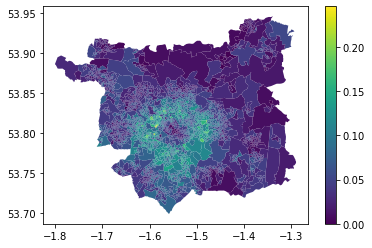

In [5]:
# Join map to travel to work data
travel_to_work= travel_to_work_by_OA_prop.merge(census_gpd, how='left', left_on='Output Areas Code', right_on='OA21CD')
# Make GeoDataFrame
travel_to_work= gpd.GeoDataFrame(travel_to_work)
# Plot a variable
travel_to_work.plot('2km to less than 5km', legend=True)

<AxesSubplot: >

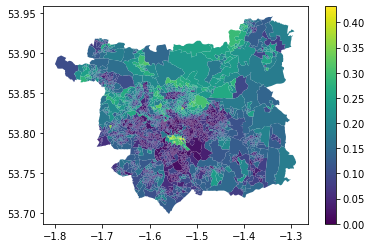

In [6]:
# Join map to NS-sec data
ns_sec =ns_sec_by_OA_prop.merge(census_gpd, how='left', left_on='Output Areas Code', right_on='OA21CD')
# Make GeoDataFrame
ns_sec= gpd.GeoDataFrame(ns_sec)
# Plot a variable
ns_sec.plot('L1, L2 and L3: Higher managerial, administrative and professional occupations', legend=True)

In [7]:
# Join data into one dataframe

travel_to_work_ns_sec=travel_to_work.merge(ns_sec[['Does not apply',
       'L1, L2 and L3: Higher managerial, administrative and professional occupations',
       'L10 and L11: Lower supervisory and technical occupations',
       'L12: Semi-routine occupations', 'L13: Routine occupations',
       'L14.1 and L14.2: Never worked and long-term unemployed',
       'L15: Full-time students',
       'L4, L5 and L6: Lower managerial, administrative and professional occupations',
       'L7: Intermediate occupations',
       'L8 and L9: Small employers and own account workers',
       'OA21CD']], on='OA21CD', how='left')

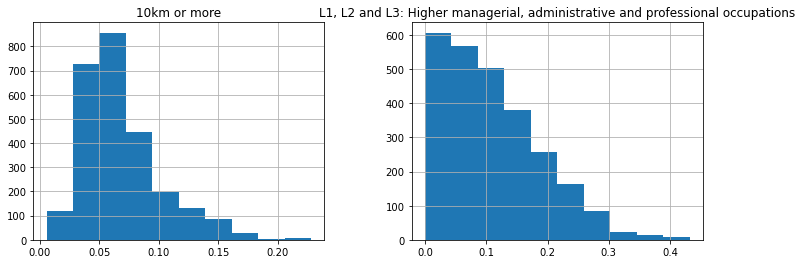

In [8]:
# Pick two variables for the bi-variate plot 
# Visualsie

travel_to_work_ns_sec[['10km or more',
                       'L1, L2 and L3: Higher managerial, administrative and professional occupations']].hist(figsize=(12,4));

# Example 1- no standardisation

Data bined into Tertiels (https://www.google.com/url?)sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiiyv-wjNv9AhUQgFwKHW-WByoQFnoECAwQAw&url=https%3A%2F%2Fen.wiktionary.org%2Fwiki%2Ftertile&usg=AOvVaw3j09s2D24LfdinR6O8Vxt-

In [9]:
# Define the bins
#bins = [0, 0.33, 0.66, 1]

# define bins for the data- bin data into Tertiles 
bins_10k=list(travel_to_work_ns_sec['10km or more'].quantile([0, 0.33, 0.66,1]))
bins_L1_L3=list(travel_to_work_ns_sec['L1, L2 and L3: Higher managerial, administrative and professional occupations'].quantile([0, 0.33, 0.66, 1]))

# Bin the first variable - x
travel_to_work_ns_sec['Var1_Class'] = pd.cut(travel_to_work_ns_sec['10km or more'], bins=bins_10k, include_lowest=True)
travel_to_work_ns_sec['Var1_Class'] = travel_to_work_ns_sec['Var1_Class'].astype('str')
print('Count of OAs in each Tertile (10km or more):\n',travel_to_work_ns_sec['Var1_Class'].value_counts(),'\n')


# Bin the second variable - y
travel_to_work_ns_sec['Var2_Class'] = pd.cut(travel_to_work_ns_sec['L1, L2 and L3: Higher managerial, administrative and professional occupations'], bins=bins_L1_L3, include_lowest=True)
travel_to_work_ns_sec['Var2_Class'] = travel_to_work_ns_sec['Var2_Class'].astype('str')
print('Count of OAs in each Tertile (L1, L2 and L3):\n',travel_to_work_ns_sec['Var2_Class'].value_counts(),'\n')


# Code created x bins to 1, 2, 3
x_class_codes = np.arange(1, len(bins_10k))
d = dict(zip(travel_to_work_ns_sec['Var1_Class'].value_counts().sort_index().index, x_class_codes))
travel_to_work_ns_sec['Var1_Class'] = travel_to_work_ns_sec['Var1_Class'].replace(d)
print('Count of OAs in each Tertile as a category (10km or more):\n',travel_to_work_ns_sec['Var1_Class'].value_counts(),'\n')

# Code created y bins to A, B, C
y_class_codes = ['A', 'B', 'C']
d = dict(zip(travel_to_work_ns_sec['Var2_Class'].value_counts().sort_index().index, y_class_codes))
travel_to_work_ns_sec['Var2_Class'] = travel_to_work_ns_sec['Var2_Class'].replace(d)
print('Count of OAs in each Tertile as a category (L1, L2 and L3):\n',travel_to_work_ns_sec['Var2_Class'].value_counts(),'\n')

# Combine x codes (1, 2, 3) and y codes ( A, B, C) to create Bi_Class 
travel_to_work_ns_sec['Bi_Class'] = travel_to_work_ns_sec['Var1_Class'].astype('str') + travel_to_work_ns_sec['Var2_Class']
print('Final Catergory counts:\n',travel_to_work_ns_sec['Bi_Class'].value_counts())

Count of OAs in each Tertile (10km or more):
 (0.0735, 0.228]      887
(0.00452, 0.0503]    861
(0.0503, 0.0735]     859
Name: Var1_Class, dtype: int64 

Count of OAs in each Tertile (L1, L2 and L3):
 (0.134, 0.432]      887
(0.0611, 0.134]     860
(-0.001, 0.0611]    860
Name: Var2_Class, dtype: int64 

Count of OAs in each Tertile as a category (10km or more):
 3    887
1    861
2    859
Name: Var1_Class, dtype: int64 

Count of OAs in each Tertile as a category (L1, L2 and L3):
 C    887
B    860
A    860
Name: Var2_Class, dtype: int64 

Final Catergory counts:
 1A    492
3C    468
3B    324
2B    295
2C    291
2A    273
1B    241
1C    128
3A     95
Name: Bi_Class, dtype: int64


/Users/francescapontin/opt/anaconda3/envs/ox/lib/python3.11/site-packages/pandas/core/arrays/categorical.py:555: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/Users/francescapontin/opt/anaconda3/envs/ox/lib/python3.11/site-packages/pandas/core/arrays/categorical.py:555: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


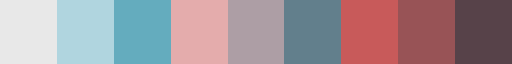

In [10]:
# Set of colors matching the elements of Bi_Class

all_colors = ['#e8e8e8', # 1A
          '#b0d5df',
          '#64acbe', # 1C
          '#e4acac', # 2A
          '#ad9ea5',
          '#627f8c', # 2C
          '#c85a5a', # 3A
          '#985356',
          '#574249'] # 3C
            
cmap = matplotlib.colors.ListedColormap(all_colors)
cmap

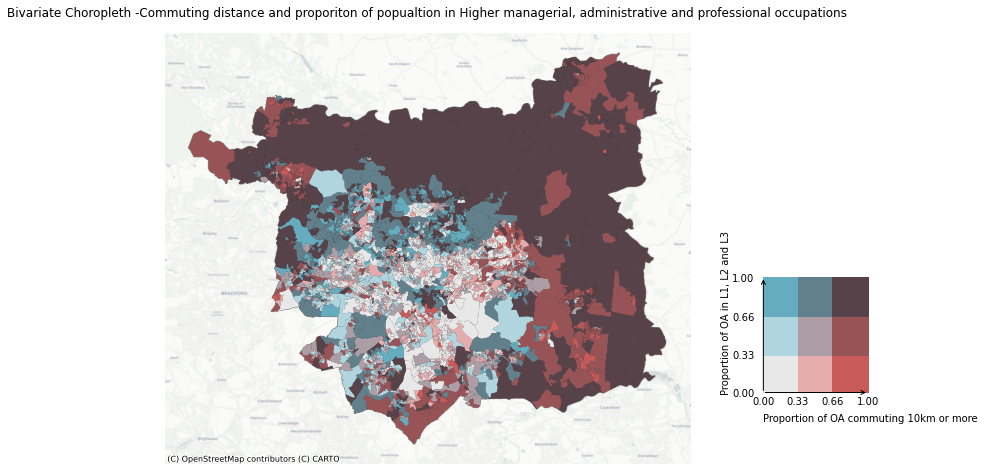

In [11]:
# Set map size
fig, ax = plt.subplots(figsize=(8,8))

# Step 1: Draw the map
# plot borders
travel_to_work_ns_sec.to_crs('EPSG:3857').plot(ax=ax, facecolor='none', edgecolor='black', alpha=.5)

# plot map
travel_to_work_ns_sec.to_crs('EPSG:3857').plot(ax=ax, 
                              column='Bi_Class', # variable that is going to be used to color the map 
                              cmap=cmap, # newly defined bivariate cmap 
                              categorical=True, # bivariate choropleth has to be colored as categorical map 
                              legend=False) # we're going to draw the legend ourselves
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron) # add the basemap

plt.tight_layout() # "tighten" two figures map and basemap
plt.axis('off') # we don't need axis with coordinates
ax.set_title('Bivariate Choropleth -Commuting distance and proporiton of popualtion in Higher managerial, administrative and professional occupations')

# Step 2: draw the legend

# We're drawing a 3x3 "box" as 3 columns
# The xmin and xmax arguments axvspan are defined to create equally sized small boxes

img2 = fig # refer to the main figure
ax2 = fig.add_axes([1.10, 0.25, 0.2, 0.2]) # add new axes to place the legend there
                                         # and specify its location 
alpha = 1 # alpha argument to make it more/less transperent

# Column 1
ax2.axvspan(xmin=0, xmax=0.33, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[0])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[1])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[2])

# Column 2
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[3])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[4])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[5])

# Column 3
ax2.axvspan(xmin=0.66, xmax=1, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[6])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[7])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[8])

# Step 3: annoate the legend
ax2.tick_params(axis='both', which='both', length=0) # remove ticks from the big box
#ax2.axis('off'); # turn off its axis
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for x 
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for y 


tick_labels=[0, 0.33, 0.66,1]
ax2.xaxis.set_ticks(tick_labels)
ax2.yaxis.set_ticks(tick_labels)
ax2.grid(False)
#ax2.set_axis_off()
ax2.set_frame_on(False)

ax2.text(s='Proportion of OA commuting 10km or more', x=0.0, y=-0.25) # annotate x axis, change x and y to move lable relative to legend axis

ax2.text(s='Proportion of OA in L1, L2 and L3', x=-0.40, y=0, rotation=90); # annotate y axis, change x and y to move lable relative to legend axis
plt.savefig('bivariate_choropleth_Leeds.png', dpi=300,bbox_inches='tight', transparent=False, facecolor='white')

# Example 2- z-score standardisation

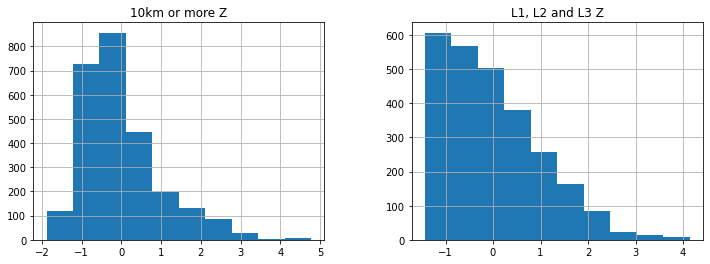

In [12]:
travel_to_work_ns_sec['10km or more Z'] =  stats.zscore(travel_to_work_ns_sec['10km or more'])

travel_to_work_ns_sec['L1, L2 and L3 Z'] =  stats.zscore(travel_to_work_ns_sec['L1, L2 and L3: Higher managerial, administrative and professional occupations'])

# visualise z-scores
travel_to_work_ns_sec[['10km or more Z','L1, L2 and L3 Z']].hist(figsize=(12,4));



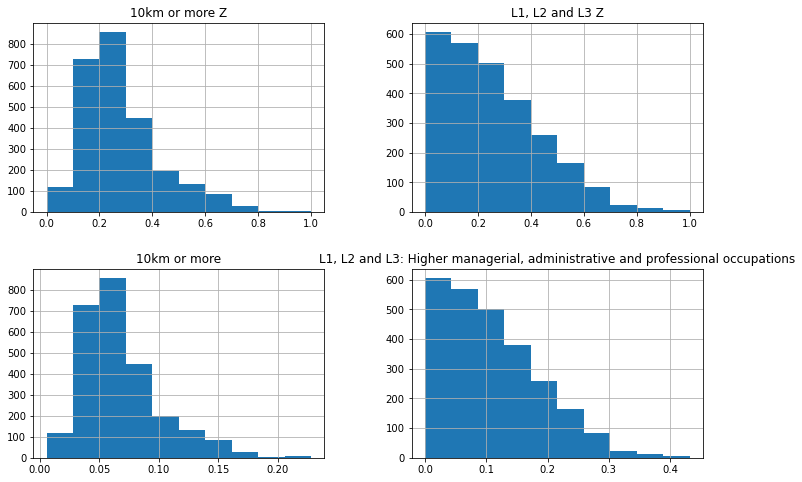

In [13]:
# Rescale z-scores to be between 0 and 1
scaler = MinMaxScaler()
travel_to_work_ns_sec[['10km or more Z','L1, L2 and L3 Z']] = scaler.fit_transform(travel_to_work_ns_sec[['10km or more Z','L1, L2 and L3 Z']])

# COMAPRE Z-SCORE STANDARDISED AND RAW PROPORTIONS
travel_to_work_ns_sec[['10km or more Z','L1, L2 and L3 Z',
                      '10km or more','L1, L2 and L3: Higher managerial, administrative and professional occupations']].hist(figsize=(12,8));

In [14]:
# Define the bins
bins = [0, 0.33, 0.66, 1] # same binning as both variables have been standardised to beteen 0 and 1

# Bin the first variable - x
travel_to_work_ns_sec['Var1_Class'] = pd.cut(travel_to_work_ns_sec['10km or more Z'], bins=bins, include_lowest=True)
travel_to_work_ns_sec['Var1_Class'] = travel_to_work_ns_sec['Var1_Class'].astype('str')
print('Count of OAs in each Tertile (10km or more):\n',travel_to_work_ns_sec['Var1_Class'].value_counts(),'\n')


# Bin the second variable - y
travel_to_work_ns_sec['Var2_Class'] = pd.cut(travel_to_work_ns_sec['L1, L2 and L3 Z'], bins=bins, include_lowest=True)
travel_to_work_ns_sec['Var2_Class'] = travel_to_work_ns_sec['Var2_Class'].astype('str')
print('Count of OAs in each Tertile (L1, L2 and L3):\n',travel_to_work_ns_sec['Var2_Class'].value_counts(),'\n')


# Code created x bins to 1, 2, 3
x_class_codes = np.arange(1, len(bins))
d = dict(zip(travel_to_work_ns_sec['Var1_Class'].value_counts().sort_index().index, x_class_codes))
travel_to_work_ns_sec['Var1_Class'] = travel_to_work_ns_sec['Var1_Class'].replace(d)
print('Count of OAs in each Tertile as a category (10km or more):\n',travel_to_work_ns_sec['Var1_Class'].value_counts(),'\n')

# Code created y bins to A, B, C
y_class_codes = ['A', 'B', 'C']
d = dict(zip(travel_to_work_ns_sec['Var2_Class'].value_counts().sort_index().index, y_class_codes))
travel_to_work_ns_sec['Var2_Class'] = travel_to_work_ns_sec['Var2_Class'].replace(d)
print('Count of OAs in each Tertile as a category (L1, L2 and L3):\n',travel_to_work_ns_sec['Var2_Class'].value_counts(),'\n')

# Combine x codes (1, 2, 3) and y codes ( A, B, C) to create Bi_Class 
travel_to_work_ns_sec['Bi_Class'] = travel_to_work_ns_sec['Var1_Class'].astype('str') + travel_to_work_ns_sec['Var2_Class']
print('Final Catergory counts:\n',travel_to_work_ns_sec['Bi_Class'].value_counts())




Count of OAs in each Tertile (10km or more):
 (-0.001, 0.33]    1853
(0.33, 0.66]       683
(0.66, 1.0]         71
Name: Var1_Class, dtype: int64 

Count of OAs in each Tertile (L1, L2 and L3):
 (-0.001, 0.33]    1808
(0.33, 0.66]       728
(0.66, 1.0]         71
Name: Var2_Class, dtype: int64 

Count of OAs in each Tertile as a category (10km or more):
 1    1853
2     683
3      71
Name: Var1_Class, dtype: int64 

Count of OAs in each Tertile as a category (L1, L2 and L3):
 A    1808
B     728
C      71
Name: Var2_Class, dtype: int64 

Final Catergory counts:
 1A    1413
1B     406
2A     360
2B     288
3A      35
2C      35
1C      34
3B      34
3C       2
Name: Bi_Class, dtype: int64


/Users/francescapontin/opt/anaconda3/envs/ox/lib/python3.11/site-packages/pandas/core/arrays/categorical.py:555: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/Users/francescapontin/opt/anaconda3/envs/ox/lib/python3.11/site-packages/pandas/core/arrays/categorical.py:555: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


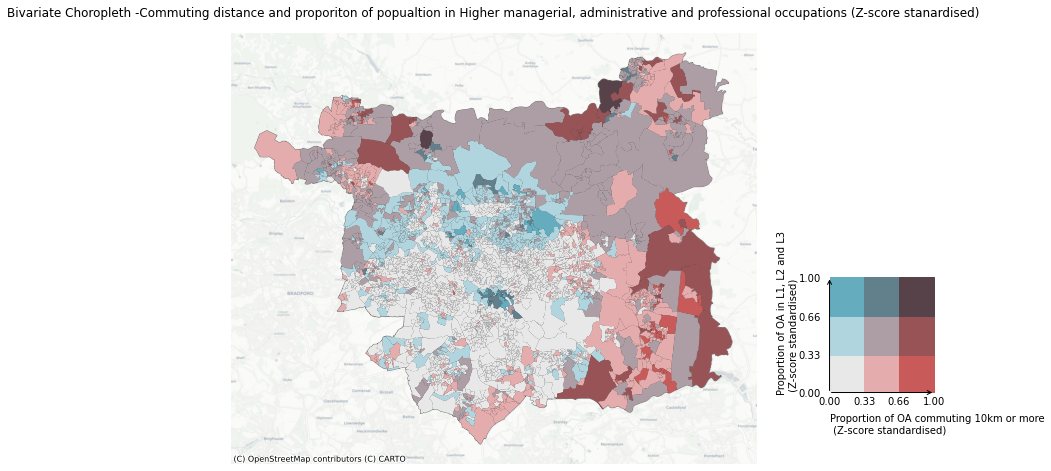

In [16]:
fig, ax = plt.subplots(figsize=(8,8))

# Step 1: Draw the map
travel_to_work_ns_sec.to_crs('EPSG:3857').plot(ax=ax, facecolor='none', edgecolor='black', alpha=.5) # city border
travel_to_work_ns_sec.to_crs('EPSG:3857').plot(ax=ax, 
                              column='Bi_Class', # variable that is going to be used to color the map 
                              cmap=cmap, # newly defined bivariate cmap 
                              categorical=True, # bivariate choropleth has to be colored as categorical map 
                              legend=False) # we're going to draw the legend ourselves
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron) # add the basemap

plt.tight_layout() # "tighten" two figures map and basemap
plt.axis('off') # we don't need axis with coordinates
ax.set_title('Bivariate Choropleth -Commuting distance and proporiton of popualtion in Higher managerial, administrative and professional occupations (Z-score stanardised)')


# Step 2: draw the legend

# We're drawing a 3x3 "box" as 3 columns
# The xmin and xmax arguments axvspan are defined to create equally sized small boxes

img2 = fig # refer to the main figure
ax2 = fig.add_axes([1.10, 0.25, 0.2, 0.2]) # add new axes to place the legend there
                                         # and specify its location 
alpha = 1 # alpha argument to make it more/less transperent

# Column 1
ax2.axvspan(xmin=0, xmax=0.33, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[0])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[1])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[2])

# Column 2
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[3])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[4])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[5])

# Column 3
ax2.axvspan(xmin=0.66, xmax=1, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[6])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[7])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[8])

# Step 3: annoate the legend
ax2.tick_params(axis='both', which='both', length=0) # remove ticks from the big box
#ax2.axis('off'); # turn off its axis
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for x 
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for y 


tick_labels=[0, 0.33, 0.66,1]
ax2.xaxis.set_ticks(tick_labels)
ax2.yaxis.set_ticks(tick_labels)
ax2.grid(False)
#ax2.set_axis_off()
ax2.set_frame_on(False)

ax2.text(s='Proportion of OA commuting 10km or more\n (Z-score standardised)', x=0.0, y=-0.35) # annotate x axis, change x and y to move lable relative to legend axis

ax2.text(s='Proportion of OA in L1, L2 and L3\n (Z-score standardised)', x=-0.50, y=0, rotation=90); # annotate y axis, change x and y to move lable relative to legend axis
plt.savefig('bivariate_choropleth_leeds_standardised.png', dpi=300,bbox_inches='tight',transparent=False, facecolor='white')